# Imports

In [1]:
from collections import Counter
import numpy as np
from numpy import ndarray
from datetime import datetime
import random
import re

EOS = '<EOS>'

# Models

In [11]:
from collections import Counter
import numpy as np
from numpy import ndarray
from datetime import datetime
import random
import re

EOS = '<EOS>'

class Model():
    input_weights = None
    output_weights = None

    negative_samples = 5

    nwords_per_line = 10
    min_words_threshold = 3

    vocabulary = None
    vocabulary_size = None
    vocabulary_index_map = None

    is_inited = False

    def __init__(self, hidden_size=100, window_size=4, weight_init_seed=31, alpha=0.01):
        self.hidden_size = hidden_size
        self.window_size = window_size
        self.weight_init_seed = weight_init_seed
        self.alpha = alpha
        self.loss_model = Loss(self, self.alpha)

    def initialise_weights(self, seed=31):
        if self.vocabulary_size is None:
            raise ValueError("Unknown Vocabulary. Run Preprocessing.")

        np.random.seed(seed)
        if self.input_weights is None:
            self.input_weights = np.random.uniform(low=-0.05, high=0.05, size=(self.vocabulary_size, self.hidden_size))
        if self.output_weights is None:
            self.output_weights = np.random.uniform(low=-0.05, high=0.05, size=(self.vocabulary_size, self.hidden_size))
        self.is_inited = True

    def __input_label_gen__(self, data:list[str]):
        for sample in data:
            tokens = [token for token in sample.split() if self.vocabulary_index_map.get(token, None) is not None]
            ntokens = len(tokens)
            for idx in range(ntokens):
                target_idx = self.vocabulary_index_map.get(tokens[idx])
                Y = target_idx
                X = []
                if idx == 0:
                    for i in range(1, min(ntokens, self.window_size + 1)):
                        label_idx = self.vocabulary_index_map.get(tokens[i])
                        X.append(label_idx)
                        yield np.array(X), Y
                elif idx == ntokens - 1:
                    for i in range(1, min(ntokens, self.window_size + 1)):
                        label_idx = self.vocabulary_index_map.get(tokens[idx - i])
                        X.append(label_idx)
                        yield np.array(X), Y
                else:
                    left = max(0, idx - self.window_size)
                    right = min(ntokens, idx + self.window_size)
                    X.extend([self.vocabulary_index_map.get(idx) for idx in tokens[left:idx]])
                    X.extend([self.vocabulary_index_map.get(idx) for idx in tokens[idx+1:right+1]])
                    yield np.array(X), Y

    def preprocess(self, f:list[str], first:int = 5000, train:bool = False, update_vocab:bool = False) -> list[str]:
        nlines = 0
        ndigits = 0
        digits = re.compile(r"(\d+)")
        unwanted_chars = re.compile(r"([^\d\w ])")
        all_words = []
        data = []

        for line in f:
            if "html" in line:
                continue

            if nlines == first:
                break

            line = re.sub(unwanted_chars, "", line)
            digits_in_line = len(re.findall(digits, line))
            line = re.sub(digits, " ## ", line).lower()
            line = re.sub(" {2,}", " ", line).strip()
            words = line.split()

            if len(words) >= self.nwords_per_line or not train:
                nlines += 1
                ndigits += digits_in_line
                all_words.extend(words)
                data.append(line + " " + EOS)

        all_words.append(EOS)

        # Return pre-processed data when mode is not in train
        if not train:
            print("Words =", len(all_words), "Lines =", nlines, "Digits =", ndigits)
            return data

        count = Counter(all_words)
        count.__setitem__(EOS, nlines)

        if self.vocabulary is None or update_vocab:
            unique_all_words = sorted(set(all_words))
            self.vocabulary = tuple(word for word in unique_all_words if count[word] > self.min_words_threshold)
            self.vocabulary_size = len(self.vocabulary)
            self.vocabulary_index_map = dict(zip(self.vocabulary, range(self.vocabulary_size)))

        data = self.__remove_less_freq_words__(data, count)

        print("Words =", len(all_words), "Vocab size =", self.vocabulary_size ,"Lines =", nlines, "Digits =", ndigits)
        return data

    def __remove_less_freq_words__(self, data:list[str], count:Counter | dict) -> list[str]:
        dataset = []
        for line in data:
            cleaned = [word for word in line.split() if count[word] > self.min_words_threshold]
            if len(cleaned) >= self.nwords_per_line:
                dataset.append(" ".join(cleaned))
        return dataset

    def fit(self, data:list[str]):
        try:
            if not self.is_inited:
                self.initialise_weights()
        except ValueError as e:
            raise e

        total_loss = 0
        n = 0

        # Streaming input
        for x, y in self.__input_label_gen__(data):
            # forward pass
            # print(x, y)
            loss = self.__fit(x, y)
            # print(f"Loss per example: {loss / (self.negative_samples + 1)}")

            total_loss += loss
            n += self.negative_samples + 1

        print(f"Average Loss: {total_loss/n:.3f}")

    def __fit(self, x:ndarray, y) -> float:
        total_loss = 0.0

        # Projection layer ->
        vectors = np.array([self.input_weights[idx] for idx in x])
        x_proj = np.average(vectors, axis=0)

        # Output layer ->
        # Positive Sampling
        z = x_proj.dot(self.output_weights[y])
        pos_y_pred = sigmoid(z)

        # Update Wout for positive sample
        loss = self.loss_model.calculate_loss(pos_y_pred, y, x_proj, 1)
        total_loss += loss

        # Negative Sampling and updating Wout
        for i in range(self.negative_samples):
            neg_y = get_neg_sample(y, self.vocabulary_size - 1)

            z = x_proj.dot(self.output_weights[neg_y])
            neg_y_pred = sigmoid(z)

            # Update Wout for negative sample
            loss = self.loss_model.calculate_loss(neg_y_pred, neg_y, x_proj, 0)
            total_loss += loss

        # Update Win
        self.loss_model.optimise(x)

        # Reset gradients for next sample
        self.loss_model.reset_grad()

        # print(f"Average Sample Loss: {total_loss / (self.negative_samples + 1)}")
        return total_loss

    def predict(self, x:list[int]) -> np.signedinteger:
        # Projection layer ->
        vectors = np.array([self.input_weights[idx] for idx in x])
        x_proj = np.average(vectors, axis=0)

        # Output layer ->
        # Positive Sampling
        z = x_proj @ self.output_weights.T

        # Returns the idx of highest score from matrix multiplication.
        # Doesn't mean probabilities or confidence unlike softmax
        y_pred = z.argmax()

        return y_pred

class Loss():
    def __init__(self, model:Model, alpha:float):
        self.model = model
        self.grad_win = np.zeros(model.hidden_size, dtype=float)
        self.alpha = alpha

        self.last_grad_win = np.zeros(model.hidden_size, dtype=float)
        self.last_grad_wout = np.zeros(model.hidden_size, dtype=float)

    def calculate_loss(self, y_pred:float, target_idx:int, x_proj:ndarray, label:int) -> float:
        loss = - (label * np.log(y_pred + 1e-7)) - ((1 - label) * np.log(1 - y_pred + 1e-7)) # +1e-7 to prevent log(0)

        err = self.alpha * (label - y_pred) # Chain rule -> y_pred - label but to descent the slope, label - y_pred

        self.grad_win += err * self.model.output_weights[target_idx]  # Accumulate gradients for Win

        grad_wout = err * x_proj # gradients for Wout
        self.last_grad_wout = grad_wout # storing last gradient for reference
        self.model.output_weights[target_idx] += grad_wout # Update Wout

        return loss

    def optimise(self, x:ndarray):
        self.grad_win = self.grad_win / len(x)
        self.last_grad_win = self.grad_win # storing last gradient for reference

        for idx in x:
            self.model.input_weights[idx] += self.grad_win

    def reset_grad(self):
        self.grad_win = np.zeros(self.model.hidden_size, dtype=float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def get_neg_sample(y:int, max_limit:int) -> int:
    random.seed(datetime.now().timestamp())
    # Uniform sampling but original implementation uses distribution that is inverse to the frequency of the tokens
    neg_y = random.randint(0, max_limit)
    while neg_y == y:
        neg_y = random.randint(0, max_limit)
    return neg_y

def train_test_split(data:list[str], seed:int=31) -> tuple[list[str], list[str]]:
    random.seed(seed)
    random.shuffle(data)
    train_size = round(len(data) * 0.8)
    train = data[0:train_size]
    test = data[train_size:]
    print("Train - ", len(train), "Test - ", len(test))
    return train, test

# Training

In [12]:
data = []
with open("../datasets/news.2025.en.shuffled.deduped") as f:
    lines = 0
    for line in f:
        data.append(line)
        lines += 1
        if lines == 5000:
            break
cbow = Model(hidden_size=50, alpha=0.01)
processed_data = cbow.preprocess(data, train=True)

Words = 116994 Vocab size = 3733 Lines = 4280 Digits = 2016


In [13]:
# # View random samples from vocabulary map
# random.sample(list(cbow.vocabulary_index_map.items()), 20)

In [14]:
epoch = 10
for i in range(1, epoch + 1):
    print("Epoch: ", i)
    cbow.fit(processed_data)

Epoch:  1
Average Loss: 0.600
Epoch:  2
Average Loss: 0.343
Epoch:  3
Average Loss: 0.313
Epoch:  4
Average Loss: 0.300
Epoch:  5
Average Loss: 0.293
Epoch:  6
Average Loss: 0.287
Epoch:  7
Average Loss: 0.282
Epoch:  8
Average Loss: 0.277
Epoch:  9
Average Loss: 0.274
Epoch:  10
Average Loss: 0.271


# Analogy Testing

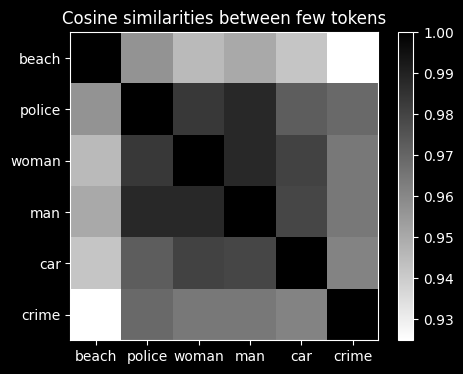

In [24]:
cbow.vocabulary_index_map.get('book')
from matplotlib import pyplot as plt

tokens = ['beach', 'police', 'woman', 'man', 'car', 'crime']
vectors = [cbow.input_weights[cbow.vocabulary_index_map.get(token)] for token in tokens]
vectors = np.array(vectors)

result = np.zeros([6, 6])
for i in range(len(vectors)):
    for j in range(len(vectors)):
        result[i][j] = np.dot(vectors[i], vectors[j]) / (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))

fig, axs = plt.subplots(figsize=(5, 4))
img = axs.imshow(result, cmap='grey_r', interpolation='nearest')
axs.set_xticks(ticks=np.arange(0, 6), labels=tokens)
axs.set_yticks(ticks=np.arange(0, 6), labels=tokens)
plt.title("Cosine similarities between few tokens")
fig.colorbar(img, ax=axs)
plt.show()